In [1]:
#installing the required packages (skforecast)
!pip install skforecast -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.0/815.0 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.5 MB/s eta 0:00:00


# model saver helper function 

In [ ]:

import os, json, joblib, pickle
from pathlib import Path

def _ensure_dir(path):
    Path(path).mkdir(parents=True, exist_ok=True)

def save_sarima_forecaster(forecaster_obj, label, metrics=None):
    root = f"saved_models/sarima/{label}"
    _ensure_dir(root)
    joblib.dump(forecaster_obj, f"{root}/sarima_forecaster.pkl")
    if metrics:
        json.dump(metrics, open(f"{root}/metrics.json", "w"))
    print(f"SARIMA forecaster saved at {root}/")

def save_arima_results(arima_results, label, metrics=None):
    root = f"saved_models/arima/{label}"
    _ensure_dir(root)
    arima_results.save(f"{root}/arima_results.pkl")
    if metrics:
        json.dump(metrics, open(f"{root}/metrics.json", "w"))
    print(f"ARIMA results saved at {root}/")




# Import required libraries

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

# skforecast imports
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax

# Statistical analysis imports
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

print("Libraries loaded successfully")

✅ Libraries loaded successfully


# Data loading and preparation

In [ ]:

# Loading youth unemployment dataset
URL_YOUTH = 'https://storage.dosm.gov.my/labour/lfs_month_youth.parquet'
df_youth = pd.read_parquet(URL_YOUTH)

# Standardizing datetime index
df_youth['date'] = pd.to_datetime(df_youth['date'])
df_youth = df_youth.set_index('date')
df_youth = df_youth.asfreq('MS')  # Monthly start

# Showing basic info
print(f"Youth dataset shape: {df_youth.shape}")
print(f"Date range: {df_youth.index.min()} to {df_youth.index.max()}")

# Extracting youth unemployment rate series for 15–24 and 15–30
unemp_15_24 = df_youth['u_rate_15_24'].copy().asfreq('MS')
unemp_15_30 = df_youth['u_rate_15_30'].copy().asfreq('MS')

# print small data overview
print("\nPreview (15–24):\n", unemp_15_24.head())
print("\nPreview (15–30):\n", unemp_15_30.head())

print(f"\nUnemployment rate series length: {len(unemp_15_24)} months (15–24)")
print(f"Unemployment rate series length: {len(unemp_15_30)} months (15–30)")



DATA LOADING AND PREPARATION (YOUTH UNEMPLOYMENT: 15–24 AND 15–30)
Youth dataset shape: (111, 4)
Date range: 2016-01-01 00:00:00 to 2025-03-01 00:00:00

Preview (15–24):
 date
2016-01-01    10.7
2016-02-01     9.0
2016-03-01    10.9
2016-04-01    11.5
2016-05-01    11.1
Freq: MS, Name: u_rate_15_24, dtype: float64

Preview (15–30):
 date
2016-01-01    6.9
2016-02-01    5.7
2016-03-01    7.0
2016-04-01    6.9
2016-05-01    6.8
Freq: MS, Name: u_rate_15_30, dtype: float64

Unemployment rate series length: 111 months (15–24)
Unemployment rate series length: 111 months (15–30)


# Data quality check

In [ ]:
def check_and_clean_data(series, name):
    """Check data quality and handle missing values"""
    print(f"\n{'-'*50}")
    print(f"Data Quality Check: {name}")
    print(f"{'-'*50}")

    print(f"Shape: {series.shape}")
    print(f"Missing values: {series.isna().sum()}")
    print(f"Data type: {series.dtype}")
    print(f"Date range: {series.index.min()} to {series.index.max()}")

    if series.isna().sum() > 0:
        print(f"Found {series.isna().sum()} missing values")

        # Check skewness for imputation method
        skewness = series.skew()
        print(f"Skewness: {skewness:.4f}")

        # Using interpolation for time series data
        series_clean = series.interpolate(method='linear', limit_direction='both')

        # Fill any remaining NAs with median
        if series_clean.isna().sum() > 0:
            fill_value = series.median()
            series_clean = series_clean.fillna(fill_value)
            print(f"Filled remaining NAs with median: {fill_value:.4f}")

        print(f"Missing values after cleaning: {series_clean.isna().sum()}")
        return series_clean
    else:
        print("No missing values found")
        return series

# Cleaning both youth unemployment series
unemp_15_24 = check_and_clean_data(unemp_15_24, "Youth Unemployment Rate (15–24)")
unemp_15_30 = check_and_clean_data(unemp_15_30, "Youth Unemployment Rate (15–30)")

# Verify data integrity
print(f"\nData cleaning completed:")
print(f"15–24 unemployment: {len(unemp_15_24)} observations, {unemp_15_24.isna().sum()} missing")
print(f"15–30 unemployment: {len(unemp_15_30)} observations, {unemp_15_30.isna().sum()} missing")



DATA QUALITY CHECK AND CLEANING (YOUTH 15–24 AND 15–30)

--------------------------------------------------
Data Quality Check: Youth Unemployment Rate (15–24)
--------------------------------------------------
Shape: (111,)
Missing values: 0
Data type: float64
Date range: 2016-01-01 00:00:00 to 2025-03-01 00:00:00
No missing values found

--------------------------------------------------
Data Quality Check: Youth Unemployment Rate (15–30)
--------------------------------------------------
Shape: (111,)
Missing values: 0
Data type: float64
Date range: 2016-01-01 00:00:00 to 2025-03-01 00:00:00
No missing values found

✅ Data cleaning completed:
15–24 unemployment: 111 observations, 0 missing
15–30 unemployment: 111 observations, 0 missing


# TRAIN-VALIDATION-TEST SPLITS (for Youth: 15–24 and 15–30)


TRAIN-VALIDATION-TEST SPLITS (YOUTH 15–24 AND 15–30)

15–24:
Train period: 2016-01-01 00:00:00 to 2021-12-01 00:00:00 (n=72)
Validation period: 2022-02-01 00:00:00 to 2023-12-01 00:00:00 (n=23)
Test period: 2024-02-01 00:00:00 to 2025-03-01 00:00:00 (n=14)

15–30:
Train period: 2016-01-01 00:00:00 to 2021-12-01 00:00:00 (n=72)
Validation period: 2022-02-01 00:00:00 to 2023-12-01 00:00:00 (n=23)
Test period: 2024-02-01 00:00:00 to 2025-03-01 00:00:00 (n=14)


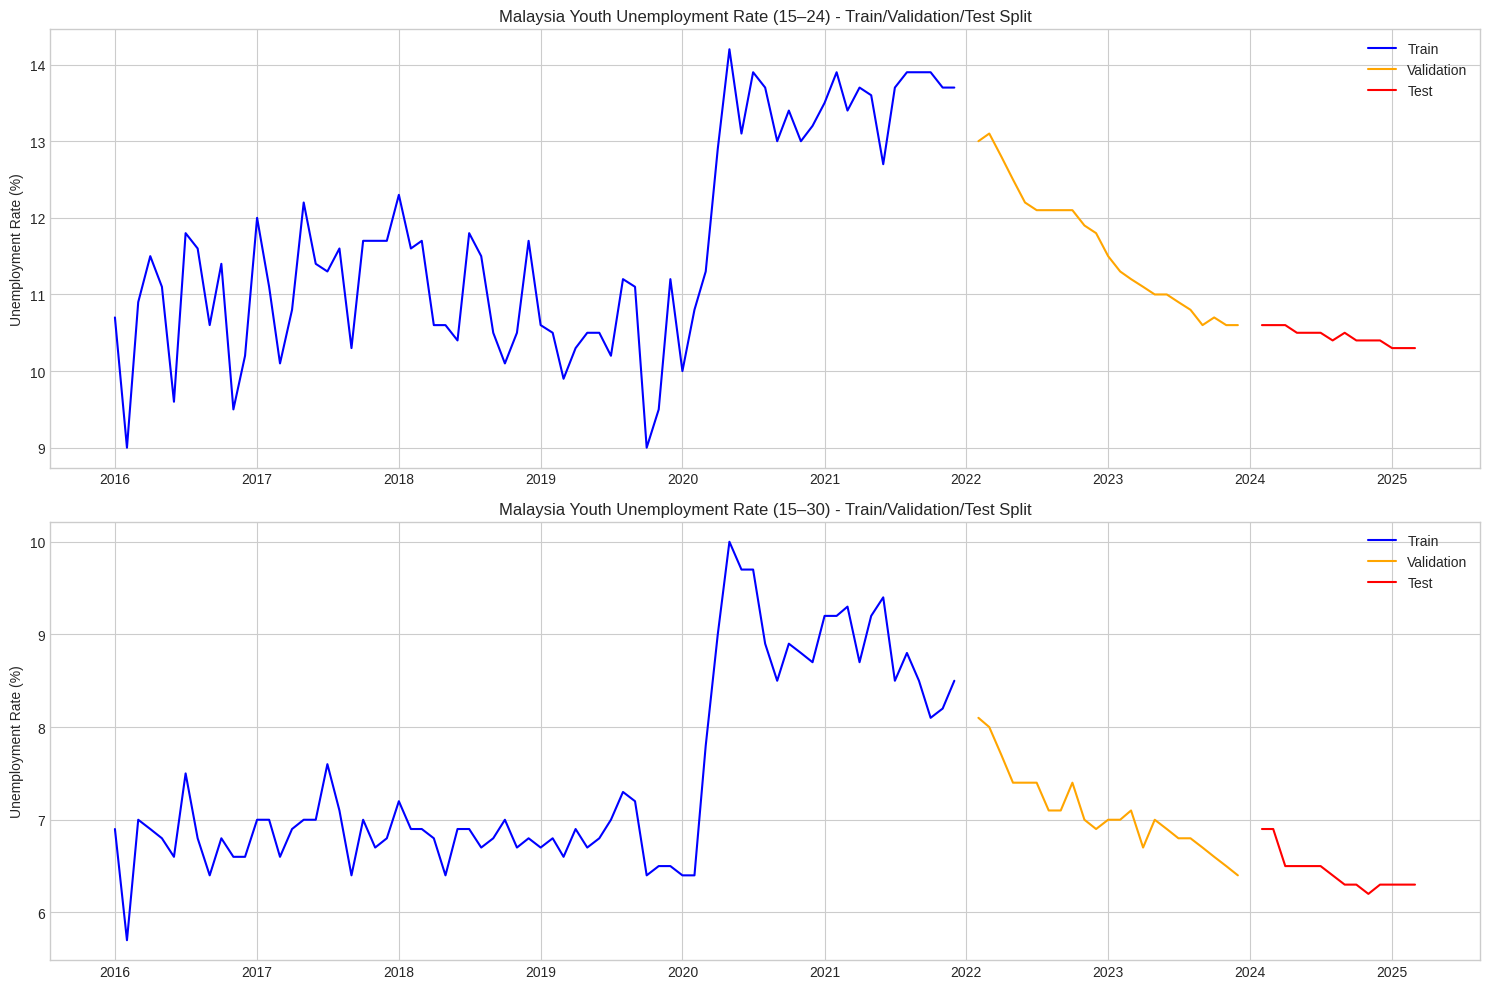

In [ ]:
# Define split dates
end_train = '2021-12-31'  # Train
end_val = '2023-12-31'    # Validation


# 15–24 youth unemployment
train_15_24 = unemp_15_24.loc[:end_train].asfreq('MS')
val_15_24 = unemp_15_24.loc[end_train:end_val].iloc[1:].asfreq('MS')
test_15_24 = unemp_15_24.loc[end_val:].iloc[1:].asfreq('MS')

# 15–30 youth unemployment
train_15_30 = unemp_15_30.loc[:end_train].asfreq('MS')
val_15_30 = unemp_15_30.loc[end_train:end_val].iloc[1:].asfreq('MS')
test_15_30 = unemp_15_30.loc[end_val:].iloc[1:].asfreq('MS')

# Print summary
print(f"\n15–24:")
print(f"Train period: {train_15_24.index.min()} to {train_15_24.index.max()} (n={len(train_15_24)})")
print(f"Validation period: {val_15_24.index.min()} to {val_15_24.index.max()} (n={len(val_15_24)})")
print(f"Test period: {test_15_24.index.min()} to {test_15_24.index.max()} (n={len(test_15_24)})")

print(f"\n15–30:")
print(f"Train period: {train_15_30.index.min()} to {train_15_30.index.max()} (n={len(train_15_30)})")
print(f"Validation period: {val_15_30.index.min()} to {val_15_30.index.max()} (n={len(val_15_30)})")
print(f"Test period: {test_15_30.index.min()} to {test_15_30.index.max()} (n={len(test_15_30)})")

# Plot splits
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 15–24 unemployment plot
axes[0].plot(train_15_24.index, train_15_24.values, label='Train', color='blue')
axes[0].plot(val_15_24.index, val_15_24.values, label='Validation', color='orange')
axes[0].plot(test_15_24.index, test_15_24.values, label='Test', color='red')
axes[0].set_title('Malaysia Youth Unemployment Rate (15–24) - Train/Validation/Test Split')
axes[0].set_ylabel('Unemployment Rate (%)')
axes[0].legend()
axes[0].grid(True)

# 15–30 unemployment plot
axes[1].plot(train_15_30.index, train_15_30.values, label='Train', color='blue')
axes[1].plot(val_15_30.index, val_15_30.values, label='Validation', color='orange')
axes[1].plot(test_15_30.index, test_15_30.values, label='Test', color='red')
axes[1].set_title('Malaysia Youth Unemployment Rate (15–30) - Train/Validation/Test Split')
axes[1].set_ylabel('Unemployment Rate (%)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


# STATIONARITY ANALYSIS (Youth Unemployment: 15–24 and 15–30)

In [ ]:

def test_stationarity(series, title):
    """Test stationarity using ADF and KPSS tests"""
    print(f"\n{'-'*60}")
    print(f"Stationarity Tests: {title}")
    print(f"{'-'*60}")

    # ADF Test
    adf_result = adfuller(series.dropna())
    print(f"ADF Test:")
    print(f"  Statistic: {adf_result[0]:.4f}")
    print(f"  p-value: {adf_result[1]:.4f}")
    print(f"  Critical Values: {adf_result[4]}")

    # KPSS Test
    kpss_result = kpss(series.dropna())
    print(f"KPSS Test:")
    print(f"  Statistic: {kpss_result[0]:.4f}")
    print(f"  p-value: {kpss_result[1]:.4f}")

    # Conclusions
    adf_stationary = adf_result[1] < 0.05
    kpss_stationary = kpss_result[1] > 0.05

    print(f"Conclusions:")
    print(f"  ADF: {'Stationary' if adf_stationary else 'Non-stationary'}")
    print(f"  KPSS: {'Stationary' if kpss_stationary else 'Non-stationary'}")

    return adf_stationary and kpss_stationary

# Test the original series
is_stationary_15_24 = test_stationarity(train_15_24, "Youth Unemployment Rate 15–24 (Original)")
is_stationary_15_30 = test_stationarity(train_15_30, "Youth Unemployment Rate 15–30 (Original)")

# Test the differenced series
train_15_24_diff = train_15_24.diff().dropna()
train_15_30_diff = train_15_30.diff().dropna()

test_stationarity(train_15_24_diff, "Youth Unemployment Rate 15–24 (First Difference)")
test_stationarity(train_15_30_diff, "Youth Unemployment Rate 15–30 (First Difference)")



STATIONARITY ANALYSIS (YOUTH 15–24 AND 15–30)

------------------------------------------------------------
Stationarity Tests: Youth Unemployment Rate 15–24 (Original)
------------------------------------------------------------
ADF Test:
  Statistic: -1.1637
  p-value: 0.6890
  Critical Values: {'1%': np.float64(-3.528889992207215), '5%': np.float64(-2.9044395987933362), '10%': np.float64(-2.589655654274312)}
KPSS Test:
  Statistic: 0.8711
  p-value: 0.0100
Conclusions:
  ADF: Non-stationary
  KPSS: Non-stationary

------------------------------------------------------------
Stationarity Tests: Youth Unemployment Rate 15–30 (Original)
------------------------------------------------------------
ADF Test:
  Statistic: -1.8569
  p-value: 0.3526
  Critical Values: {'1%': np.float64(-3.526004646825607), '5%': np.float64(-2.9032002348069774), '10%': np.float64(-2.5889948363419957)}
KPSS Test:
  Statistic: 0.8411
  p-value: 0.0100
Conclusions:
  ADF: Non-stationary
  KPSS: Non-stationary


<ipython-input-7-7da382de7ef5>:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna())
<ipython-input-7-7da382de7ef5>:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna())
<ipython-input-7-7da382de7ef5>:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna())
<ipython-input-7-7da382de7ef5>:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna())


np.True_

# ACF/PACF ANALYSIS (Youth Unemployment: 15–24 and 15–30)


ACF/PACF ANALYSIS (YOUTH 15–24 AND 15–30)


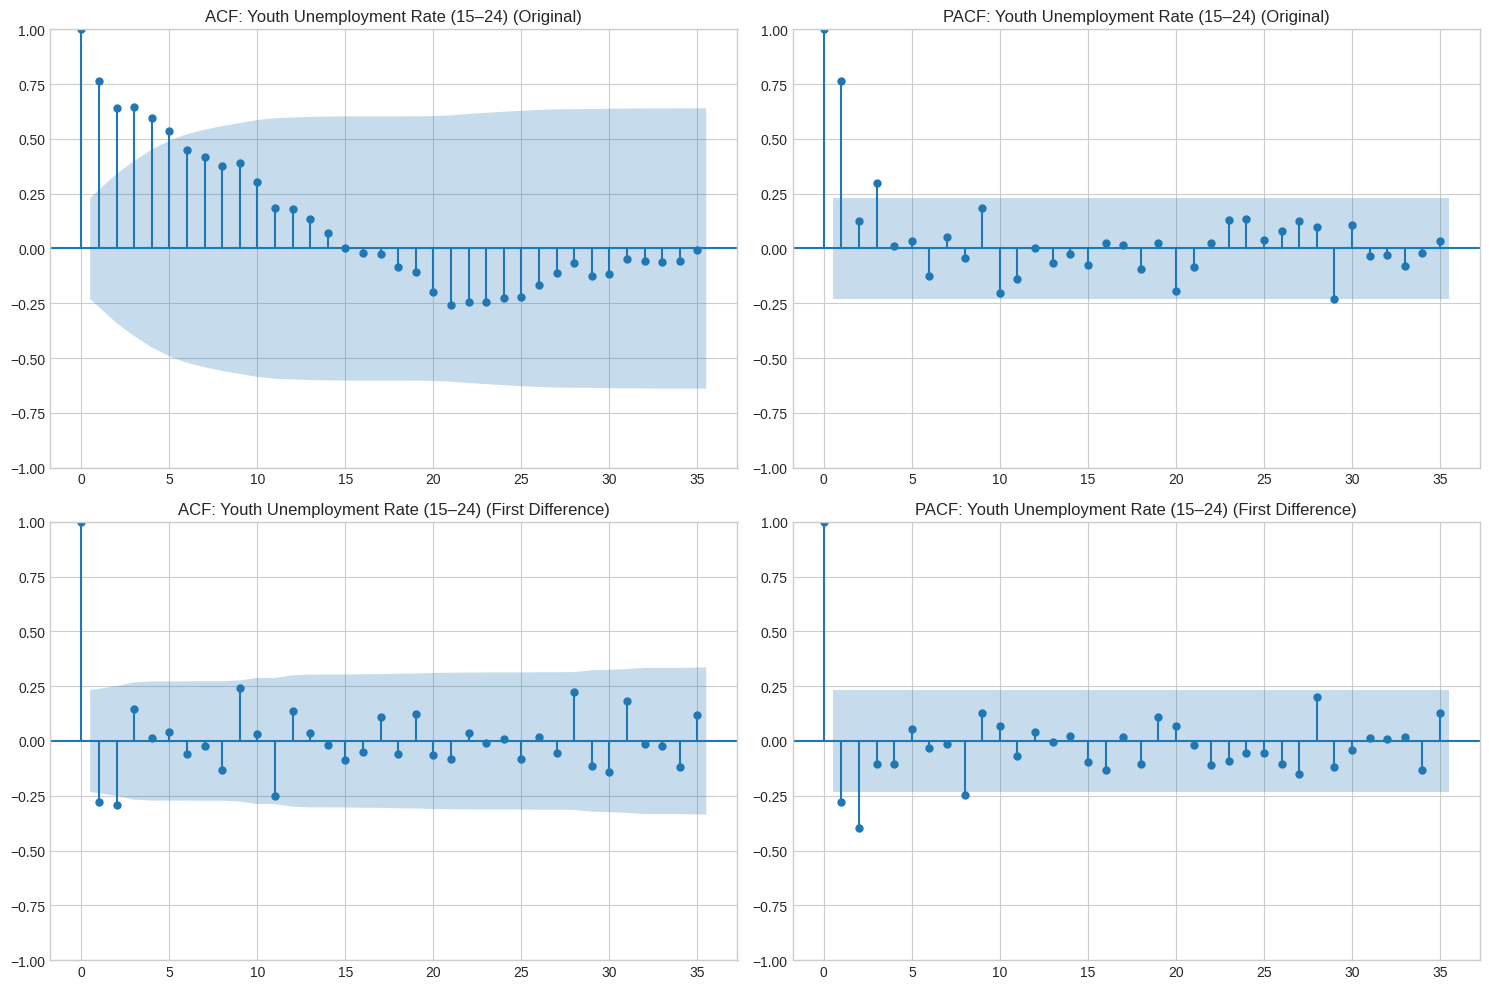

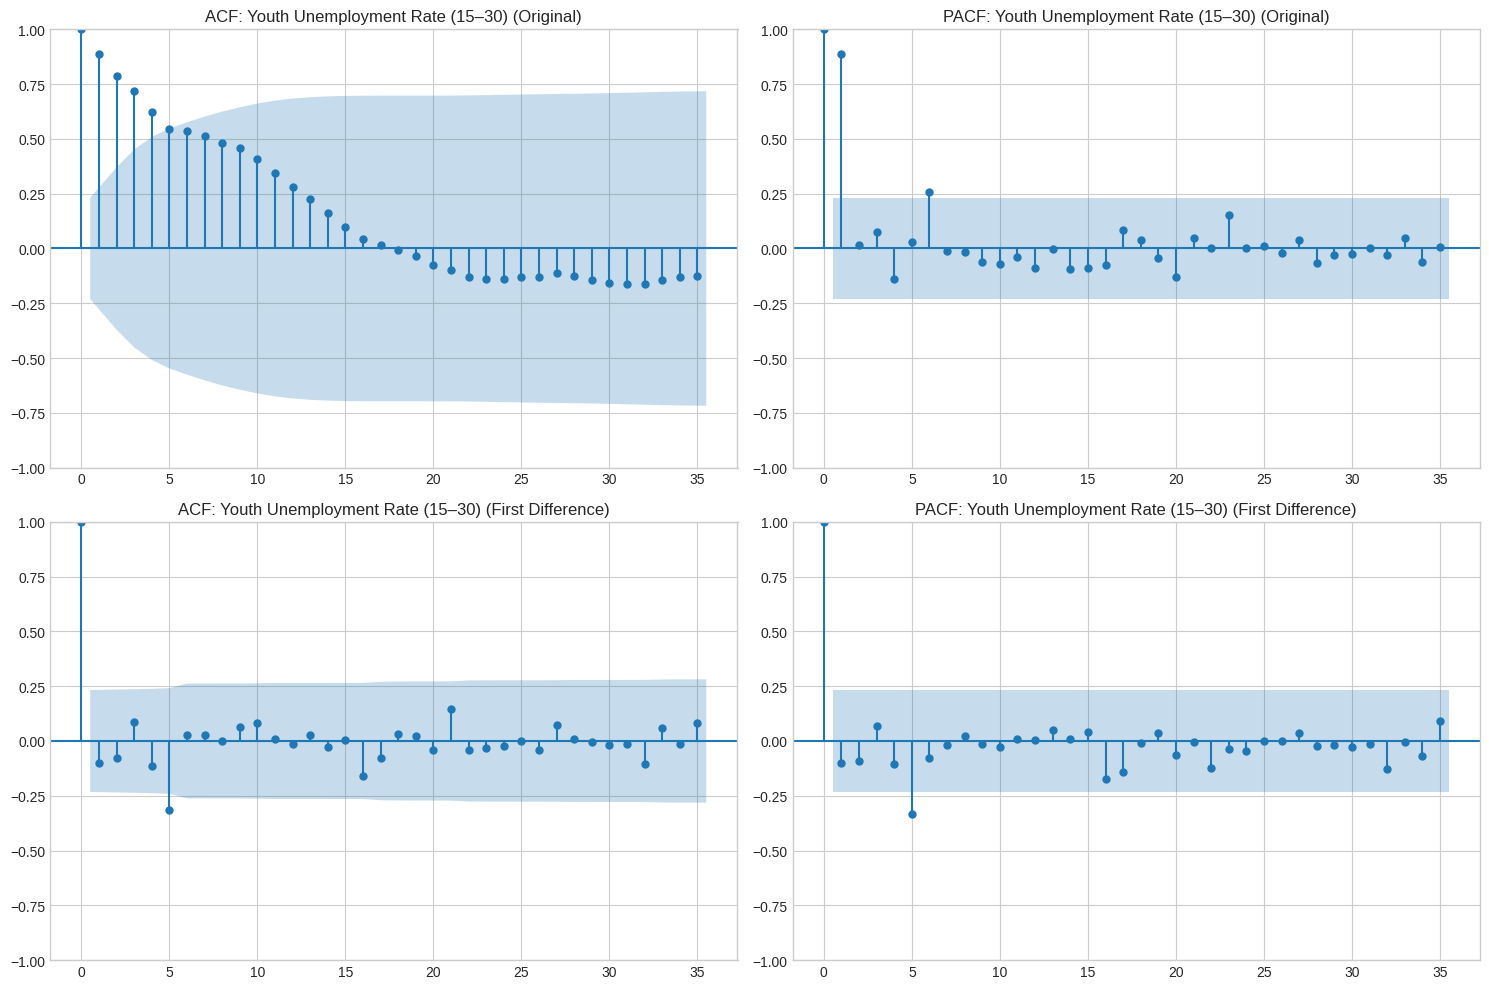

In [ ]:


def plot_acf_pacf_analysis(series, title, max_lags=40):
    """Plot ACF and PACF for both original and differenced series"""
    series_diff = series.diff().dropna()

    # Dynamically limit lags to avoid error
    effective_lags = min(max_lags, len(series_diff) // 2)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # ACF original
    plot_acf(series.dropna(), ax=axes[0, 0], lags=effective_lags, alpha=0.05)
    axes[0, 0].set_title(f'ACF: {title} (Original)')

    # PACF original
    plot_pacf(series.dropna(), ax=axes[0, 1], lags=effective_lags, alpha=0.05)
    axes[0, 1].set_title(f'PACF: {title} (Original)')

    # ACF differenced
    plot_acf(series_diff, ax=axes[1, 0], lags=effective_lags, alpha=0.05)
    axes[1, 0].set_title(f'ACF: {title} (First Difference)')

    # PACF differenced
    plot_pacf(series_diff, ax=axes[1, 1], lags=effective_lags, alpha=0.05)
    axes[1, 1].set_title(f'PACF: {title} (First Difference)')

    plt.tight_layout()
    plt.show()


# Analyze youth unemployment rates
plot_acf_pacf_analysis(train_15_24, "Youth Unemployment Rate (15–24)")
plot_acf_pacf_analysis(train_15_30, "Youth Unemployment Rate (15–30)")


# installing packages for ceemdan decomposition


In [ ]:
!pip install EMD-signal -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.14.4 requires dill<0.3.8,>=0.3.0, but you have dill 0.4.0 which is incompatible.


# CEEMDAN DECOMPOSITION (for LSTM)


CEEMDAN DECOMPOSITION


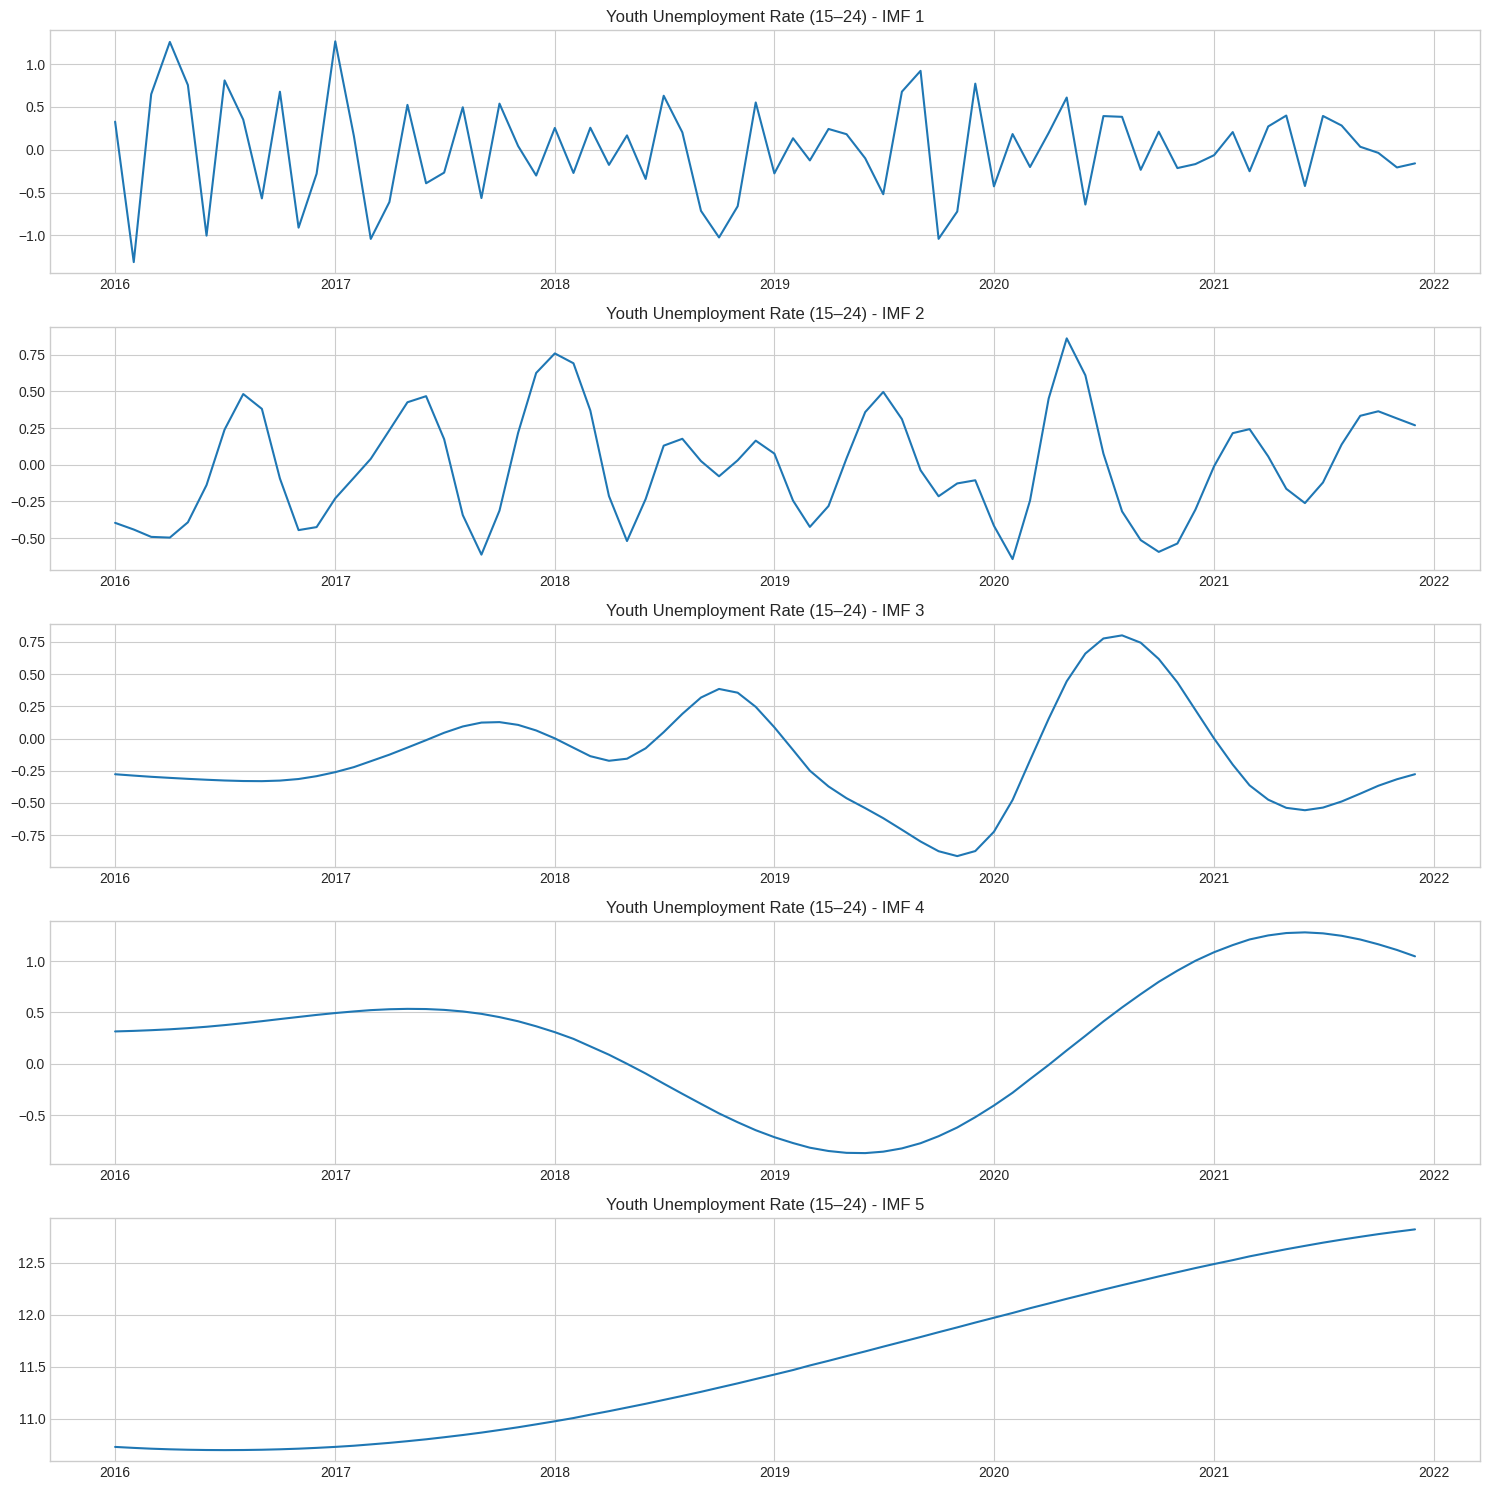

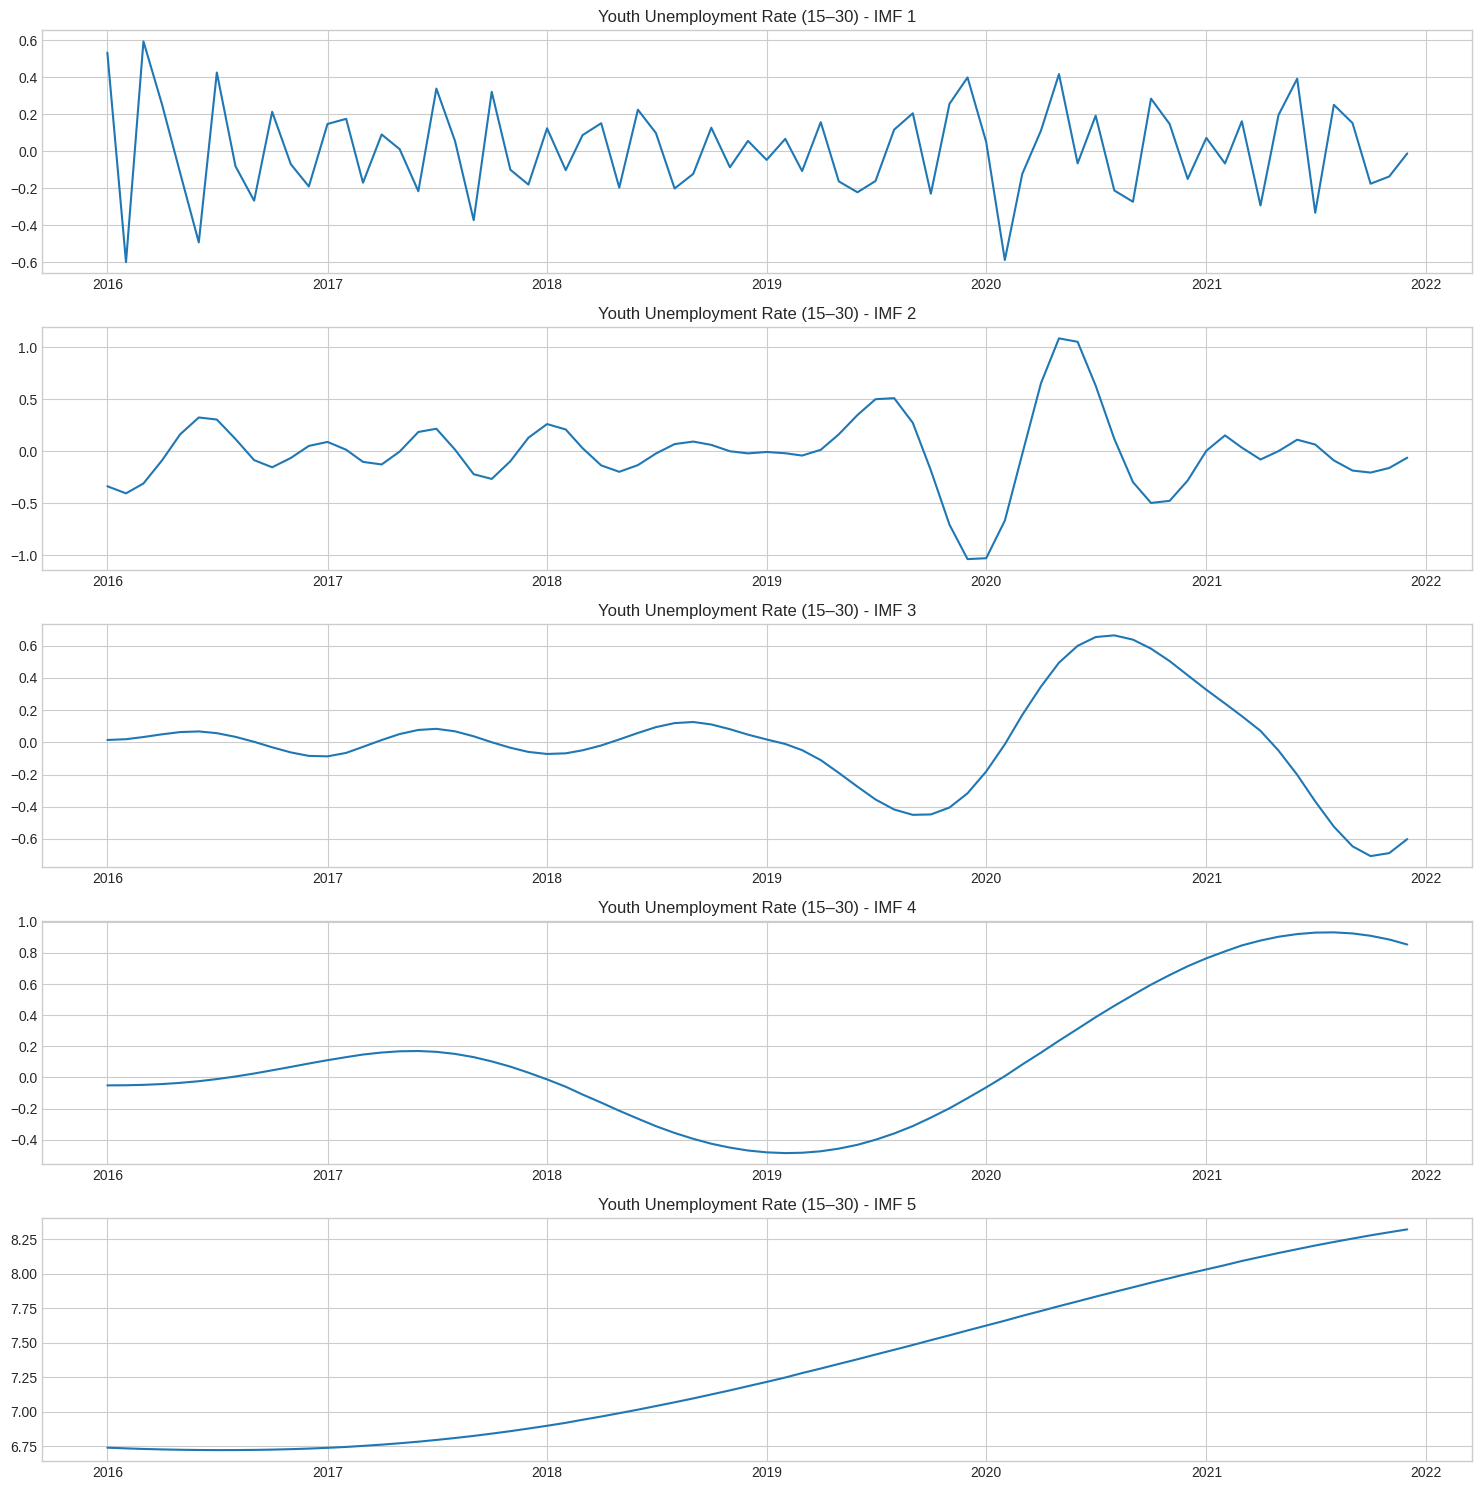

In [ ]:
from PyEMD import CEEMDAN

def plot_ceemdan_decomposition(series, title):
    """Apply CEEMDAN and plot IMFs"""
    ceemdan = CEEMDAN()
    imfs = ceemdan.ceemdan(series.dropna().values)
    n_imfs = len(imfs)

    fig, axes = plt.subplots(n_imfs, 1, figsize=(15, 3 * n_imfs))
    if n_imfs == 1:
        axes = [axes]

    for i, imf in enumerate(imfs):
        axes[i].plot(series.index[:len(imf)], imf)
        axes[i].set_title(f'{title} - IMF {i+1}')
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

    return imfs

# Applying CEEMDAN to both youth unemployment series then plot
imfs_15_24 = plot_ceemdan_decomposition(train_15_24, "Youth Unemployment Rate (15–24)")
imfs_15_30 = plot_ceemdan_decomposition(train_15_30, "Youth Unemployment Rate (15–30)")


# SEASONAL DECOMPOSITION (s/arima)

In [ ]:
def plot_seasonal_decomposition(series, title):
    """Plot seasonal decomposition"""
    decomposition = seasonal_decompose(series.dropna(), model='additive', period=12)

    fig, axes = plt.subplots(4, 1, figsize=(15, 12))

    decomposition.observed.plot(ax=axes[0], title=f'{title} - Original')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual')

    plt.tight_layout()
    plt.show()

    return decomposition

# Decomposed youth unemployment series
decomp_15_24 = plot_seasonal_decomposition(train_15_24, "Youth Unemployment Rate (15–24)")
decomp_15_30 = plot_seasonal_decomposition(train_15_30, "Youth Unemployment Rate (15–30)")


# SARIMA MODEL SELECTION WITH MISSING VALUE HANDLING

In [ ]:
# grid based parameter search space
param_grid = {
    'order': [
        (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1),  # Non-seasonal parameters
        (0, 1, 2), (2, 1, 2) 
    ],
    'seasonal_order': [
        (0, 1, 1, 12), (1, 1, 1, 12), (2, 1, 1, 12),  # Seasonal parameters
        (1, 1, 2, 12), (2, 1, 2, 12)
    ],
    'trend': [None, 'c']  
}

print(f"Grid search will test {len(param_grid['order']) * len(param_grid['seasonal_order']) * len(param_grid['trend'])} combinations")

def handle_missing_values(series, method='auto'):
    """
    Handle missing values using appropriate imputation method based on skewness
    """
    print(f"\nHandling missing values for series:")
    print(f"Original length: {len(series)}")
    print(f"Missing values: {series.isna().sum()}")

    if series.isna().sum() == 0:
        print("No missing values found")
        return series

    # Calculate skewness to determine imputation method
    skewness = series.skew()
    print(f"Skewness: {skewness:.4f}")

    if method == 'auto':
        if abs(skewness) < 0.5:  # Approximately normal distribution
            impute_value = series.mean()
            method_used = 'mean'
        else:  # Skewed distribution
            impute_value = series.median()
            method_used = 'median'
    elif method == 'mean':
        impute_value = series.mean()
        method_used = 'mean'
    elif method == 'median':
        impute_value = series.median()
        method_used = 'median'
    elif method == 'interpolate':
        # Linear interpolation for time series
        series_filled = series.interpolate(method='linear', limit_direction='both')
        print(f"Used linear interpolation")
        print(f"Remaining missing values after interpolation: {series_filled.isna().sum()}")

        # Fill any remaining missing values with median
        if series_filled.isna().sum() > 0:
            series_filled = series_filled.fillna(series.median())
            print(f"Filled remaining NaNs with median: {series.median():.4f}")

        return series_filled

    # Filling missing values if any
    series_filled = series.fillna(impute_value)
    print(f"Used {method_used} imputation: {impute_value:.4f}")
    print(f"Missing values after imputation: {series_filled.isna().sum()}")

    return series_filled

def prepare_data_for_grid_search_with_imputation(train_data, val_data):
    """Properly combine and clean data for grid search"""
    print(f"\nPreparing data for grid search...")

    # Ensure both have proper frequency
    train_clean = train_data.asfreq('MS')
    val_clean = val_data.asfreq('MS')

    # Combine with proper indexing
    combined = pd.concat([train_clean, val_clean])
    combined = combined.asfreq('MS')  # To ensure frequency is maintained

    print(f"Combined data shape: {combined.shape}")
    print(f"Date range: {combined.index.min()} to {combined.index.max()}")

    # Handleing missing values using interpolation for time series
    combined_clean = handle_missing_values(combined, method='interpolate')

    return combined_clean

# Prepareing data for grid search tackeling missing values as well
full_data_15_24 = prepare_data_for_grid_search_with_imputation(train_15_24, val_15_24)
full_data_15_30 = prepare_data_for_grid_search_with_imputation(train_15_30, val_15_30)

print(f"\nFinal data for grid search:")
print(f"15-24 - Length: {len(full_data_15_24)}, Missing: {full_data_15_24.isna().sum()}")
print(f"15-30 - Length: {len(full_data_15_30)}, Missing: {full_data_15_30.isna().sum()}")

# Set up the time series for cross-validation
cv = TimeSeriesFold(
    steps=6,  # 6-months ahead of test forecasts
    initial_train_size=len(train_15_24),
    refit=True,
    fixed_train_size=False
)

def perform_grid_search_with_validation(data_series, series_name):
    """Perform grid search for SARIMA parameters with proper validation"""
    print(f"\nPerforming grid search for {series_name}...")
    print(f"Data validation:")
    print(f"  Length: {len(data_series)}")
    print(f"  Missing values: {data_series.isna().sum()}")
    print(f"  Data type: {type(data_series)}")
    print(f"  Index type: {type(data_series.index)}")
    print(f"  Frequency: {data_series.index.freq}")

    # Final validation - ensure no missing values
    if data_series.isna().sum() > 0:
        print(" Still have missing values, applying final cleanup...")
        data_series = data_series.fillna(method='ffill').fillna(method='bfill')
        print(f"Missing values after final cleanup: {data_series.isna().sum()}")

    forecaster = ForecasterSarimax(
        regressor=Sarimax(order=(1, 1, 1), maxiter=500)
    )

    try:
        results = grid_search_sarimax(
            forecaster=forecaster,
            y=data_series,
            cv=cv,
            param_grid=param_grid,
            metric='mean_absolute_error',
            return_best=False,
            suppress_warnings_fit=True,
            verbose=False
        )
        return results
    except Exception as e:
        print(f"Grid search failed: {e}")
        print("Trying with smaller parameter grid...")

        param_grid_small = {
            'order': [(1, 1, 1), (0, 1, 1), (2, 1, 1)],
            'seasonal_order': [(1, 1, 1, 12), (0, 1, 1, 12)],
            'trend': [None, 'c']
        }

        results = grid_search_sarimax(
            forecaster=forecaster,
            y=data_series,
            cv=cv,
            param_grid=param_grid_small,
            metric='mean_absolute_error',
            return_best=False,
            suppress_warnings_fit=True,
            verbose=False
        )
        return results

# Perform grid search for both series
print("Grid Search for Unemployment rate frome 15-24:")
results_15_24 = perform_grid_search_with_validation(full_data_15_24, "u_rate_15-24")

print("\nGrid Search for Unemployment rate frome 15-30:")
results_15_30 = perform_grid_search_with_validation(full_data_15_30, "u_rate_15-30")

print("Grid search completed successfully!")


SARIMA MODEL SELECTION WITH GRID SEARCH
Grid search will test 60 combinations

Preparing data for grid search...
Combined data shape: (96,)
Date range: 2016-01-01 00:00:00 to 2023-12-01 00:00:00

Handling missing values for series:
Original length: 96
Missing values: 1
Skewness: 0.2913
Used linear interpolation
Remaining missing values after interpolation: 0

Preparing data for grid search...
Combined data shape: (96,)
Date range: 2016-01-01 00:00:00 to 2023-12-01 00:00:00

Handling missing values for series:
Original length: 96
Missing values: 1
Skewness: 1.1471
Used linear interpolation
Remaining missing values after interpolation: 0

Final data for grid search:
15-24 - Length: 96, Missing: 0
15-30 - Length: 96, Missing: 0
Grid Search for Unemployment rate frome 15-24:

Performing grid search for u_rate_15-24...
Data validation:
  Length: 96
  Missing values: 0
  Data type: <class 'pandas.core.series.Series'>
  Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
  Freq

params grid:   0%|          | 0/60 [00:00<?, ?it/s]


Grid Search for Unemployment rate frome 15-30:

Performing grid search for u_rate_15-30...
Data validation:
  Length: 96
  Missing values: 0
  Data type: <class 'pandas.core.series.Series'>
  Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
  Frequency: <MonthBegin>
Number of models compared: 60.


params grid:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Grid search completed successfully!


# DISPLAY BEST RESULTS

In [ ]:
print("\nTop 5 models for Youth Unemployment Rate (15–24):")
print(results_15_24.head())

print("\nTop 5 models for Youth Unemployment Rate (15–30):")
print(results_15_30.head())

# Getting best parameters list
best_params_15_24 = results_15_24.iloc[0]
best_params_15_30 = results_15_30.iloc[0]

print(f"\nBest parameters for 15–24: {best_params_15_24['params']}")
print(f"Best MAE for 15–24: {best_params_15_24['mean_absolute_error']:.4f}")

print(f"\nBest parameters for 15–30: {best_params_15_30['params']}")
print(f"Best MAE for 15–30: {best_params_15_30['mean_absolute_error']:.4f}")



BEST SARIMA PARAMETERS

Top 5 models for Youth Unemployment Rate (15–24):
                                              params  mean_absolute_error  \
0  {'order': (1, 1, 0), 'seasonal_order': (2, 1, ...             0.606559   
1  {'order': (1, 1, 0), 'seasonal_order': (2, 1, ...             0.615385   
2  {'order': (1, 1, 0), 'seasonal_order': (1, 1, ...             0.624765   
3  {'order': (1, 1, 0), 'seasonal_order': (1, 1, ...             0.633018   
4  {'order': (1, 1, 0), 'seasonal_order': (2, 1, ...             0.647111   

       order seasonal_order trend  
0  (1, 1, 0)  (2, 1, 2, 12)     c  
1  (1, 1, 0)  (2, 1, 1, 12)     c  
2  (1, 1, 0)  (1, 1, 2, 12)     c  
3  (1, 1, 0)  (1, 1, 1, 12)     c  
4  (1, 1, 0)  (2, 1, 2, 12)  None  

Top 5 models for Youth Unemployment Rate (15–30):
                                              params  mean_absolute_error  \
0  {'order': (2, 1, 1), 'seasonal_order': (0, 1, ...             0.403195   
1  {'order': (0, 1, 2), 'seasonal_order':

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()


# TRAINING BEST SARIMA MODELS FOR YOUTH SERIES

In [ ]:
# Extracting best parameters
def extract_sarima_params_fixed(params_row):
    """Extract SARIMA parameters from grid search results - handles both dict and string"""
    if isinstance(params_row, str):
        param_dict = eval(params_row)
    elif isinstance(params_row, dict):
        param_dict = params_row
    else:
        param_dict = params_row

    return {
        'order': param_dict['order'],
        'seasonal_order': param_dict['seasonal_order'],
        'trend': param_dict.get('trend', None)
    }

# Try extracting best parameters from results
try:
    params_15_24 = extract_sarima_params_fixed(results_15_24.iloc[0]['params'])
    params_15_30 = extract_sarima_params_fixed(results_15_30.iloc[0]['params'])
except:
    params_dict_15_24 = dict(results_15_24.iloc[0])
    params_dict_15_30 = dict(results_15_30.iloc[0])

    if isinstance(params_dict_15_24['params'], str):
        params_15_24 = extract_sarima_params_fixed(eval(params_dict_15_24['params']))
        params_15_30 = extract_sarima_params_fixed(eval(params_dict_15_30['params']))
    else:
        params_15_24 = extract_sarima_params_fixed(params_dict_15_24['params'])
        params_15_30 = extract_sarima_params_fixed(params_dict_15_30['params'])

print(f"\nTraining SARIMA{params_15_24['order']}x{params_15_24['seasonal_order']} for 15–24")
print(f"Training SARIMA{params_15_30['order']}x{params_15_30['seasonal_order']} for 15–30")

# Train final SARIMA models
forecaster_15_24 = ForecasterSarimax(
    regressor=Sarimax(
        order=params_15_24['order'],
        seasonal_order=params_15_24['seasonal_order'],
        trend=params_15_24['trend'],
        maxiter=500
    )
)
forecaster_15_24.fit(y=train_15_24, suppress_warnings=True)

forecaster_15_30 = ForecasterSarimax(
    regressor=Sarimax(
        order=params_15_30['order'],
        seasonal_order=params_15_30['seasonal_order'],
        trend=params_15_30['trend'],
        maxiter=500
    )
)
forecaster_15_30.fit(y=train_15_30, suppress_warnings=True)

print("\n Final SARIMA models for 15–24 and 15–30 trained successfully.")

# Display selected parameters
print(f"\n Selected SARIMA Parameters:")
print(f"15–24: SARIMA{params_15_24['order']} x {params_15_24['seasonal_order']} Trend: {params_15_24['trend']}")
print(f"15–30: SARIMA{params_15_30['order']} x {params_15_30['seasonal_order']} Trend: {params_15_30['trend']}")



TRAINING BEST SARIMA MODELS FOR YOUTH (15–24 and 15–30)

Training SARIMA(1, 1, 0)x(2, 1, 2, 12) for 15–24
Training SARIMA(2, 1, 1)x(0, 1, 1, 12) for 15–30

✅ Final SARIMA models for 15–24 and 15–30 trained successfully.

📊 Selected SARIMA Parameters:
15–24: SARIMA(1, 1, 0) x (2, 1, 2, 12) Trend: c
15–30: SARIMA(2, 1, 1) x (0, 1, 1, 12) Trend: None


# GENERATE FORECASTS (FIXED FOR 15–24 AND 15–30)

In [ ]:
#  Forecast on validation set
print("Generating validation forecasts...")
forecast_val_15_24 = forecaster_15_24.predict(steps=len(val_15_24))
forecast_val_15_30 = forecaster_15_30.predict(steps=len(val_15_30))

# Combine train + val and retrain for final test forecast
def combine_and_clean_data(train_data, val_data, name):
    print(f"\nCombining data for {name}:")
    combined = pd.concat([train_data, val_data]).asfreq('MS')
    print(f"Combined length: {len(combined)}, missing: {combined.isna().sum()}")

    if combined.isna().sum() > 0:
        print("Cleaning missing values...")
        combined = combined.interpolate(method='linear', limit_direction='both')
        combined = combined.fillna(method='ffill').fillna(method='bfill')
        print(f"After cleaning: {combined.isna().sum()} missing")

    return combined

trainval_15_24 = combine_and_clean_data(train_15_24, val_15_24, "15–24")
trainval_15_30 = combine_and_clean_data(train_15_30, val_15_30, "15–30")

# Retrain models on combined train+val
forecaster_15_24_updated = ForecasterSarimax(
    regressor=Sarimax(
        order=params_15_24['order'],
        seasonal_order=params_15_24['seasonal_order'],
        trend=params_15_24['trend'],
        maxiter=500
    )
)
forecaster_15_24_updated.fit(y=trainval_15_24, suppress_warnings=True)

forecaster_15_30_updated = ForecasterSarimax(
    regressor=Sarimax(
        order=params_15_30['order'],
        seasonal_order=params_15_30['seasonal_order'],
        trend=params_15_30['trend'],
        maxiter=500
    )
)
forecaster_15_30_updated.fit(y=trainval_15_30, suppress_warnings=True)

# Generate test forecasts
print("Generating test forecasts...")
forecast_test_15_24 = forecaster_15_24_updated.predict(steps=len(test_15_24))
forecast_test_15_30 = forecaster_15_30_updated.predict(steps=len(test_15_30))

print("All forecasts generated successfully")

#  Display forecast summary
print(f"\n Forecast Summary:")
print(f"15–24 Validation Forecasts: {len(forecast_val_15_24)} | Period: {forecast_val_15_24.index[0]} to {forecast_val_15_24.index[-1]}")
print(f"15–30 Validation Forecasts: {len(forecast_val_15_30)} | Period: {forecast_val_15_30.index[0]} to {forecast_val_15_30.index[-1]}")
print(f"15–24 Test Forecasts: {len(forecast_test_15_24)} | Period: {forecast_test_15_24.index[0]} to {forecast_test_15_24.index[-1]}")
print(f"15–30 Test Forecasts: {len(forecast_test_15_30)} | Period: {forecast_test_15_30.index[0]} to {forecast_test_15_30.index[-1]}")



GENERATING FORECASTS FOR 15–24 AND 15–30
Generating validation forecasts...

Combining data for 15–24:
Combined length: 96, missing: 1
Cleaning missing values...
After cleaning: 0 missing

Combining data for 15–30:
Combined length: 96, missing: 1
Cleaning missing values...
After cleaning: 0 missing


<ipython-input-19-6ff33b130094>:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined = combined.fillna(method='ffill').fillna(method='bfill')


Generating test forecasts...
✅ All forecasts generated successfully

📊 Forecast Summary:
15–24 Validation Forecasts: 23 | Period: 2022-01-01 00:00:00 to 2023-11-01 00:00:00
15–30 Validation Forecasts: 23 | Period: 2022-01-01 00:00:00 to 2023-11-01 00:00:00
15–24 Test Forecasts: 14 | Period: 2024-01-01 00:00:00 to 2025-02-01 00:00:00
15–30 Test Forecasts: 14 | Period: 2024-01-01 00:00:00 to 2025-02-01 00:00:00


# MODEL EVALUATION METRICS (FOR BOTH 15–24 and 15–30)

In [ ]:


from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_metrics(actual, predicted, series_name, period):
    """Calculate comprehensive evaluation metrics"""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    print(f"\n{series_name} - {period} Period:")
    print(f"  MAE:  {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.2f}%")

    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Validation Period
metrics_15_24_val = calculate_metrics(val_15_24.values, forecast_val_15_24.values,
                                      "Youth Unemployment (15–24)", "Validation")
metrics_15_30_val = calculate_metrics(val_15_30.values, forecast_val_15_30.values,
                                      "Youth Unemployment (15–30)", "Validation")

# Test Period
metrics_15_24_test = calculate_metrics(test_15_24.values, forecast_test_15_24.values,
                                       "Youth Unemployment (15–24)", "Test")
metrics_15_30_test = calculate_metrics(test_15_30.values, forecast_test_15_30.values,
                                       "Youth Unemployment (15–30)", "Test")



MODEL EVALUATION METRICS (15–24 and 15–30)

Youth Unemployment (15–24) - Validation Period:
  MAE:  3.0429
  RMSE: 3.3172
  MAPE: 27.06%

Youth Unemployment (15–30) - Validation Period:
  MAE:  1.9484
  RMSE: 2.0526
  MAPE: 28.08%

Youth Unemployment (15–24) - Test Period:
  MAE:  0.3571
  RMSE: 0.4198
  MAPE: 3.43%

Youth Unemployment (15–30) - Test Period:
  MAE:  0.2406
  RMSE: 0.2865
  MAPE: 3.70%


In [ ]:
# SAVE SARIMA FORECASTERS
save_sarima_forecaster(forecaster_15_24_updated,
                       label="15_24",
                       metrics={"MAE": metrics_15_24_test['MAE'],
                                "RMSE": metrics_15_24_test['RMSE'],
                                "MAPE": metrics_15_24_test['MAPE']})
save_sarima_forecaster(forecaster_15_30_updated,
                       label="15_30",
                       metrics={"MAE": metrics_15_30_test['MAE'],
                                "RMSE": metrics_15_30_test['RMSE'],
                                "MAPE": metrics_15_30_test['MAPE']})


# FINAL VISUALIZATION (FOR 15–24 AND 15–30)


VISUALIZATION OF FORECASTING RESULTS (15–24 and 15–30)


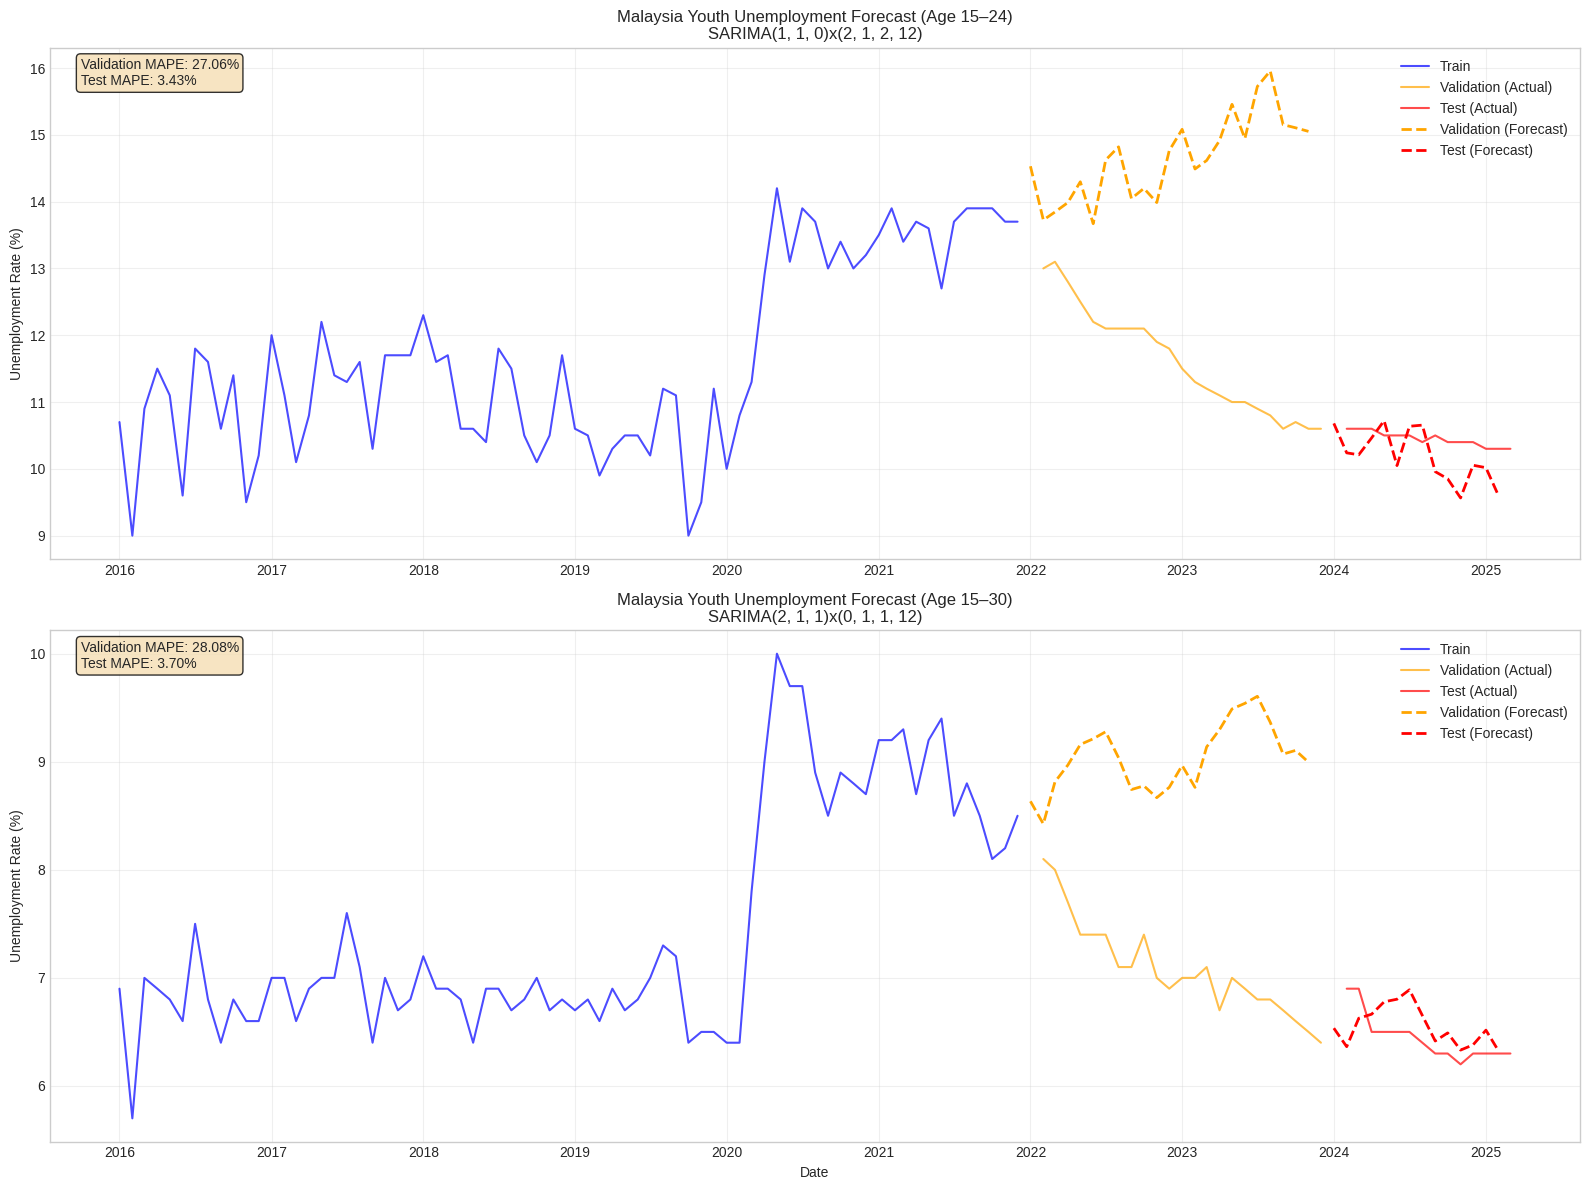


🚀 Youth SARIMA Forecasting Complete!
📊 Best Model (15–24): SARIMA(1, 1, 0)x(2, 1, 2, 12)
📊 Best Model (15–30): SARIMA(2, 1, 1)x(0, 1, 1, 12)
🎯 Models ready for reporting and policy recommendation.


In [ ]:
# forecast visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Youth Unemployment 15–24
axes[0].plot(train_15_24.index, train_15_24.values, label='Train', color='blue', alpha=0.7)
axes[0].plot(val_15_24.index, val_15_24.values, label='Validation (Actual)', color='orange', alpha=0.7)
axes[0].plot(test_15_24.index, test_15_24.values, label='Test (Actual)', color='red', alpha=0.7)
axes[0].plot(forecast_val_15_24.index, forecast_val_15_24.values,
             label='Validation (Forecast)', linestyle='--', color='orange', linewidth=2)
axes[0].plot(forecast_test_15_24.index, forecast_test_15_24.values,
             label='Test (Forecast)', linestyle='--', color='red', linewidth=2)

axes[0].set_title(f'Malaysia Youth Unemployment Forecast (Age 15–24)\nSARIMA{params_15_24["order"]}x{params_15_24["seasonal_order"]}')
axes[0].set_ylabel('Unemployment Rate (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Adding metrics
axes[0].text(0.02, 0.98, f'Validation MAPE: {metrics_15_24_val["MAPE"]:.2f}%\nTest MAPE: {metrics_15_24_test["MAPE"]:.2f}%',
             transform=axes[0].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Youth Unemployment 15–30
axes[1].plot(train_15_30.index, train_15_30.values, label='Train', color='blue', alpha=0.7)
axes[1].plot(val_15_30.index, val_15_30.values, label='Validation (Actual)', color='orange', alpha=0.7)
axes[1].plot(test_15_30.index, test_15_30.values, label='Test (Actual)', color='red', alpha=0.7)
axes[1].plot(forecast_val_15_30.index, forecast_val_15_30.values,
             label='Validation (Forecast)', linestyle='--', color='orange', linewidth=2)
axes[1].plot(forecast_test_15_30.index, forecast_test_15_30.values,
             label='Test (Forecast)', linestyle='--', color='red', linewidth=2)

axes[1].set_title(f'Malaysia Youth Unemployment Forecast (Age 15–30)\nSARIMA{params_15_30["order"]}x{params_15_30["seasonal_order"]}')
axes[1].set_ylabel('Unemployment Rate (%)')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Adding metrics
axes[1].text(0.02, 0.98, f'Validation MAPE: {metrics_15_30_val["MAPE"]:.2f}%\nTest MAPE: {metrics_15_30_test["MAPE"]:.2f}%',
             transform=axes[1].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n Youth SARIMA Forecasting Complete!")
print(f" Best Model (15–24): SARIMA{params_15_24['order']}x{params_15_24['seasonal_order']}")
print(f" Best Model (15–30): SARIMA{params_15_30['order']}x{params_15_30['seasonal_order']}")
print(f" Models ready for reporting and policy recommendation.")


# ARIMA MODEL

In [ ]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Define parameter grid
p = d = q = range(0, 3)
param_combinations = list(itertools.product(p, d, q))

def arima_grid_search(series, param_grid):
    best_score = float('inf')
    best_cfg = None
    results = []

    for param in param_grid:
        try:
            model = ARIMA(series, order=param)
            model_fit = model.fit()
            mae = mean_absolute_error(series, model_fit.fittedvalues)
            results.append((param, mae))
            if mae < best_score:
                best_score = mae
                best_cfg = param
        except:
            continue
    return pd.DataFrame(results, columns=["params", "mae"]).sort_values(by="mae"), best_cfg

# Combine training and validation
train_val_15_24 = pd.concat([train_15_24, val_15_24])
results_15_24, best_order_15_24 = arima_grid_search(train_val_15_24, param_combinations)

print("Top 5 ARIMA(15-24) configs:")
print(results_15_24.head())
print(f"Best ARIMA Order: {best_order_15_24}")


<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/l

Top 5 ARIMA(15-24) configs:
       params       mae
20  (2, 0, 2)  0.519551
11  (1, 0, 2)  0.532900
19  (2, 0, 1)  0.538312
10  (1, 0, 1)  0.539807
18  (2, 0, 0)  0.555529
Best ARIMA Order: (2, 0, 2)


In [ ]:
# Fit best model
final_model_15_24 = ARIMA(train_val_15_24, order=best_order_15_24)
final_fit_15_24 = final_model_15_24.fit()

# Forecast into test set
forecast_15_24 = final_fit_15_24.forecast(steps=len(test_15_24))
forecast_15_24.index = test_15_24.index


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mae = mean_absolute_error(test_15_24, forecast_15_24)
rmse = np.sqrt(mean_squared_error(test_15_24, forecast_15_24))
mape = np.mean(np.abs((test_15_24 - forecast_15_24) / test_15_24)) * 100

print(f"\nEvaluation Metrics for ARIMA (15–24):")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")



Evaluation Metrics for ARIMA (15–24):
MAE:  0.4778
RMSE: 0.5205
MAPE: 4.59%


In [ ]:
# SAVE ARIMA RESULTS
save_arima_results(final_fit_15_24, label="15_24",
                   metrics={"MAE": mae, "RMSE": rmse, "MAPE": mape})


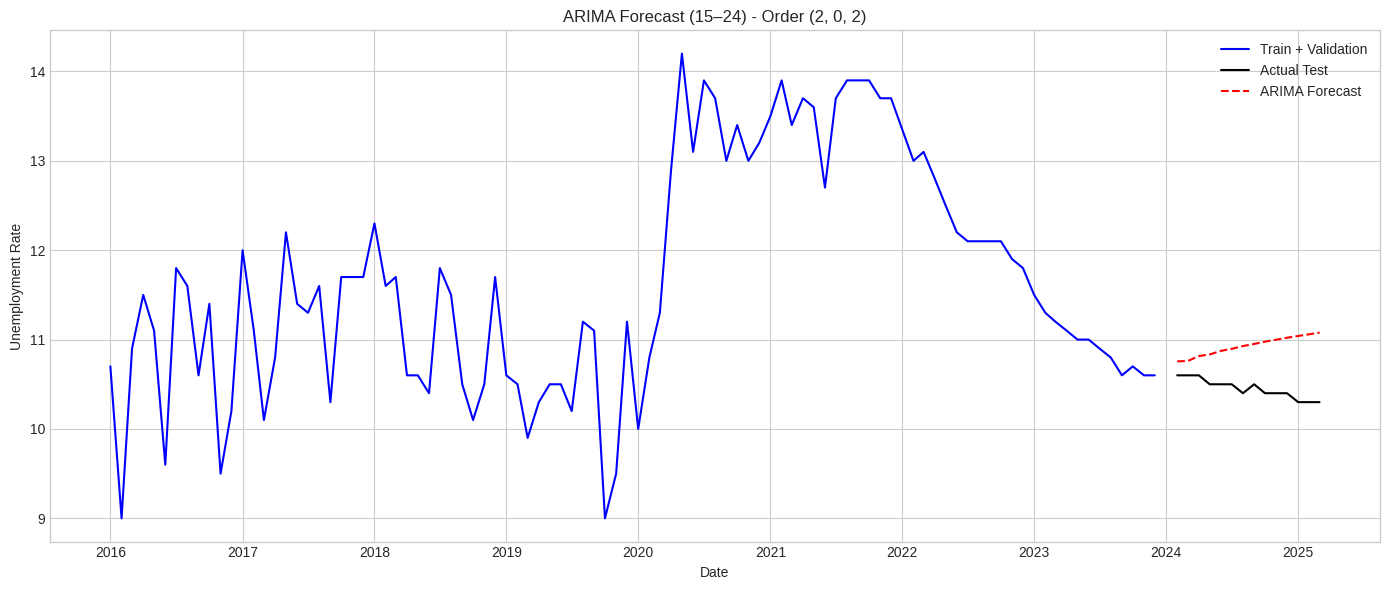

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(train_val_15_24.index, train_val_15_24, label='Train + Validation', color='blue')
plt.plot(test_15_24.index, test_15_24, label='Actual Test', color='black')
plt.plot(forecast_15_24.index, forecast_15_24, label='ARIMA Forecast', color='red', linestyle='--')

plt.title(f'ARIMA Forecast (15–24) - Order {best_order_15_24}')
plt.xlabel("Date")
plt.ylabel("Unemployment Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Define parameter grid
p = d = q = range(0, 3)
param_combinations = list(itertools.product(p, d, q))

def arima_grid_search(series, param_grid):
    best_score = float('inf')
    best_cfg = None
    results = []

    for param in param_grid:
        try:
            model = ARIMA(series, order=param)
            model_fit = model.fit()
            mae = mean_absolute_error(series, model_fit.fittedvalues)
            results.append((param, mae))
            if mae < best_score:
                best_score = mae
                best_cfg = param
        except:
            continue
    return pd.DataFrame(results, columns=["params", "mae"]).sort_values(by="mae"), best_cfg

# Combine training and validation
train_val_15_30 = pd.concat([train_15_30, val_15_30])
results_15_30, best_order_15_30 = arima_grid_search(train_val_15_30, param_combinations)

print("Top 5 ARIMA(15-30) configs:")
print(results_15_30.head())
print(f"Best ARIMA Order: {best_order_15_30}")


In [ ]:
# Fit best model
final_model_15_30 = ARIMA(train_val_15_30, order=best_order_15_30)
final_fit_15_30 = final_model_15_30.fit()

# Forecast into test set
forecast_15_30 = final_fit_15_30.forecast(steps=len(test_15_30))
forecast_15_30.index = test_15_30.index


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mae = mean_absolute_error(test_15_30, forecast_15_30)
rmse = np.sqrt(mean_squared_error(test_15_30, forecast_15_30))
mape = np.mean(np.abs((test_15_30 - forecast_15_30) / test_15_30)) * 100

print(f"\nEvaluation Metrics for ARIMA (15–24):")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


In [ ]:
save_arima_results(final_fit_15_30, label="15_30",
                   metrics={"MAE": mae, "RMSE": rmse, "MAPE": mape})


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(train_val_15_30.index, train_val_15_30, label='Train + Validation', color='blue')
plt.plot(test_15_30.index, test_15_30, label='Actual Test', color='black')
plt.plot(forecast_15_30.index, forecast_15_30, label='ARIMA Forecast', color='red', linestyle='--')

plt.title(f'ARIMA Forecast (15–30) - Order {best_order_15_30}')
plt.xlabel("Date")
plt.ylabel("Unemployment Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
